In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import operator
import mpl_toolkits
mpl_toolkits.__path__.append('/usr/lib/python2.7/dist-packages/mpl_toolkits/')
#from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm
from numpy.random import RandomState
from scipy.stats import ttest_ind
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from datetime import timedelta  
from sklearn.utils import shuffle

#from tabulate import tabulate

from keras import Sequential, backend, regularizers
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend

Using TensorFlow backend.


# Import train, test, validation data

In [8]:
import os
training_data = pd.read_csv(os.getcwd()+'/data_for_classifier/dedup_training_data.csv')
val_data = pd.read_csv(os.getcwd()+'/data_for_classifier/dedup_val_data.csv')

1837 205


In [47]:
int2label = {'0':'agree','1':'disagree','2':'neutral','3':'neutral'}

In [48]:
test_data = {'sent':[],'label':[],'source':[]}

In [49]:
for med_bias in ['anti','pro']:
    with open(os.path.join('../','test_data/{}-cc/test_data_text_only.txt'.format(med_bias)))\
    as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if len(line) > 0:
                split_line = line.split('\t\t')
                text = split_line[0]
                label = split_line[-1]
                if len(label) == 1:
                    str_label = int2label[label]
                    source = med_bias
                    test_data['sent'].append(text)
                    test_data['label'].append(str_label)
                    test_data['source'].append(source)

In [50]:
test_data_df = pd.DataFrame(test_data)

In [52]:
test_data_df['source'].value_counts()

pro     445
anti    384
Name: source, dtype: int64

In [51]:
test_data_df['label'].value_counts()

neutral     627
agree       129
disagree     73
Name: label, dtype: int64

In [54]:
test_data_df

,sent,label,source
0,We ’re also doing some avian and marine mammal...,neutral,anti
1,"In preconstruction monitoring , we ’re looking...",neutral,anti
2,“ This project will have to address the marine...,neutral,anti
3,N.J. “ It is a project with a lot of potential...,neutral,anti
4,that studies need to be done,neutral,anti
...,...,...,...
824,"Thus , as in any facet of life , we must make ...",neutral,pro
825,whether a doubling of CO2 will ultimately resu...,neutral,pro
826,what is a ridiculously complex phenomenon into...,neutral,pro
827,Even if we know some of these are far more imp...,neutral,pro


In [56]:
print(len(training_data), len(val_data), len(test_data_df))

1837 205 829


In [88]:
#generate the corpus for training and validation data that will be use for different featurizations
corpus_all = training_data[pd.isnull(training_data['sent_clean'])==False]
corpus_all.reset_index(inplace=True)
corpus_all.to_csv('corpus.csv', sep=',')
corpus_all = corpus_all[pd.isnull(corpus_all['max_prob_label'])==False]
corpus_all.reset_index(inplace=True)
corpus = corpus_all['sent_clean']
corpus_val = val_data[pd.isnull(val_data['sent_clean'])==False]
corpus_val.reset_index(inplace=True)
corpus_val = corpus_val[pd.isnull(corpus_val['max_prob_label'])==False]
corpus_val.reset_index(inplace=True)
print("length of the corpus: ",len(corpus))

# outcomes for RNN
Y_train = corpus_all['max_prob_label']
Y_val = corpus_val['max_prob_label']
Y_test = test_data_df['label']
Y_train_float = corpus_all['max_prob_label'].apply(label2float)
Y_val_float = corpus_val['max_prob_label'].apply(label2float)
Y_test_float = test_data_df['label'].apply(label2float)

length of the corpus:  1837


# Unigram Featurization methods: NB, k-means, SVM (rbf and linear kernel), RNN

In [89]:
# Basic unigram featurization of tweets that are not in the validation/test set 
# Find unigram features
vectorizerCount = CountVectorizer(stop_words='english',binary=True)
train_unigram = vectorizerCount.fit_transform(corpus).toarray()
test_unigram = vectorizerCount.transform(test_data_df['sent']).toarray()
val_unigram = vectorizerCount.transform(corpus_val['sent_clean']).toarray()

In [90]:
# Fit Bernoulli naive bayes
bnb_uni = BernoulliNB(alpha=1)
bnb_uni.fit(train_unigram, corpus_all['max_prob_label'].apply(label2float))

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

In [91]:
#validation and test error for Bernouilli Naive Bayes
pred_val = bnb_uni.predict(val_unigram)
score_val_u1 = metrics.accuracy_score(corpus_val['max_prob_label'].apply(label2float), 
                                      pred_val)
pred = bnb_uni.predict(test_unigram)
score_u1 = metrics.accuracy_score(test_data_df['label'].apply(label2float), pred)
print("validation accuracy:   %0.3f" % score_val_u1)
print("test accuracy:   %0.3f" % score_u1)

validation accuracy:   0.634
test accuracy:   0.698


In [92]:
# perform k-means (with k=2) in test and validation sets
kmeans_val = KMeans(n_clusters=2, init = 'random', n_init = 10).fit(val_unigram)
kmeans = KMeans(n_clusters=2, init = 'random', n_init = 10).fit(test_unigram)

# Check errors with k-means
pred1_val = kmeans_val.labels_*(2)-1
pred2_val = pred1_val*(-1)
score1_val = metrics.accuracy_score(corpus_val['max_prob_label'].apply(label2float),
                                    pred1_val)
score2_val = metrics.accuracy_score(corpus_val['max_prob_label'].apply(label2float),
                                    pred2_val)
score_val_u2 = max(score1_val,score2_val)
print("validation accuracy:   %0.3f" % score_val_u2)

pred1 = kmeans.labels_*(2)-1
pred2 = pred1*(-1)
score1 = metrics.accuracy_score(test_data_df['label'].apply(label2float), pred1)
score2 = metrics.accuracy_score(test_data_df['label'].apply(label2float), pred2)
score_u2 = max(score1,score2)
print("test accuracy:   %0.3f" % score_u2)

validation accuracy:   0.332
test accuracy:   0.159


In [93]:
# Classify using linear SVM
clf = svm.SVC(kernel='linear') #gamma='scale'
clf.fit(train_unigram, corpus_all['max_prob_label'].apply(label2float))  
pred_val = clf.predict(val_unigram)
score_val_u4 = metrics.accuracy_score(corpus_val['max_prob_label'].apply(label2float),
                                      pred_val)
pred = clf.predict(test_unigram)
score_u4 = metrics.accuracy_score(test_data_df['label'].apply(label2float), pred)
print("validation accuracy:   %0.3f" % score_val_u4)
print("test accuracy:   %0.3f" % score_u4)

validation accuracy:   0.610
test accuracy:   0.683


In [63]:
embeddings_index = {}
f = open('/Users/yiweiluo/Downloads/datasets/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = ' '.join(values[0:len(values)-300])
    try:
        coefs = np.asarray(values[len(values)-300:], dtype='float32')
    except ValueError:
        print(line)
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2195895 word vectors.


In [66]:
def label2float(x):
    if x == 'agree':
        return 1.0
    elif x == 'disagree':
        return -1.0
    else:
        return 0.0

In [72]:
Y_train_float = Y_train.apply(label2float)
Y_val_float = Y_val.apply(label2float)
Y_test_float = Y_test.apply(label2float)

In [81]:
Y_train_float


0       1.0
1       1.0
2       0.0
3       0.0
4       1.0
       ... 
1832    1.0
1833    1.0
1834    1.0
1835   -1.0
1836    0.0
Name: max_prob_label, Length: 1837, dtype: float64

In [94]:
# RNN

voc_size = 8000
max_words = 50
tokenizer = Tokenizer(num_words=voc_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
X_train = tokenizer.texts_to_sequences(corpus)
X_train = pad_sequences(X_train,maxlen=max_words)
X_val = tokenizer.texts_to_sequences(corpus_val['sent_clean'])
X_val = pad_sequences(X_val,maxlen=max_words)
X_test = tokenizer.texts_to_sequences(test_data_df['sent'])
X_test = pad_sequences(X_test,maxlen=max_words)

EMBEDDING_DIM=300
MAX_SEQUENCE_LENGTH=max_words
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH
                            #,
                            #trainable=False
                           )

lstm_size = 20
dense_layer = 250
backend.clear_session()
model=Sequential()
model.add(embedding_layer)# input_length=max_words))#,dropout = 0.2
#model.add(Dense(dense_layer, activation='relu'))
#model.add(LSTM(lstm_size,return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(lstm_size,dropout=0.4, recurrent_dropout=0.4, activation='relu'))
#model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])
batch_size = 64
num_epochs = 5
#X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
#X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]
history = model.fit(X_train, Y_train_float, validation_data=(X_val, Y_val_float), 
                    batch_size=batch_size, epochs=num_epochs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           1467000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                25680     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,492,701
Trainable params: 1,492,701
Non-trainable params: 0
_________________________________________________________________
None


/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1837 samples, validate on 205 samples
Epoch 1/5
1837/1837 [==============================] - 3s 2ms/step - loss: 3.3037 - accuracy: 0.4208 - val_loss: 0.5958 - val_accuracy: 0.4390
Epoch 2/5
1837/1837 [==============================] - 2s 1ms/step - loss: 0.5085 - accuracy: 0.4192 - val_loss: 0.5872 - val_accuracy: 0.4390
Epoch 3/5
1837/1837 [==============================] - 2s 1ms/step - loss: 0.4638 - accuracy: 0.4208 - val_loss: 0.5666 - val_accuracy: 0.4390
Epoch 4/5
1837/1837 [==============================] - 2s 1ms/step - loss: 0.4275 - accuracy: 0.4197 - val_loss: 0.5495 - val_accuracy: 0.4390
Epoch 5/5
1837/1837 [==============================] - 2s 1ms/step - loss: 0.4023 - accuracy: 0.4203 - val_loss: 0.5390 - val_accuracy: 0.4390


validation accuracy:   0.439
test accuracy:   0.756


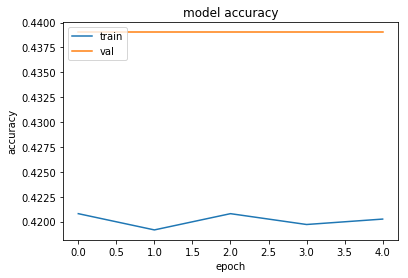

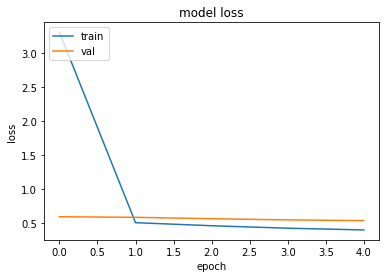

In [95]:
score_val_t5 = history.history['val_accuracy'][-1]
score_t5 = model.evaluate(X_test, Y_test_float, verbose=0)[1]

print("validation accuracy:   %0.3f" % score_val_t5)
print("test accuracy:   %0.3f" % score_t5)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [96]:
X_pred = model.predict(X_test)

(array([ 12.,  17.,  16.,  56., 123., 193., 197., 124.,  83.,   8.]),
 array([0.06061256, 0.10045499, 0.14029741, 0.18013984, 0.21998227,
        0.2598247 , 0.29966712, 0.33950955, 0.37935197, 0.4191944 ,
        0.45903683], dtype=float32),
 <a list of 10 Patch objects>)

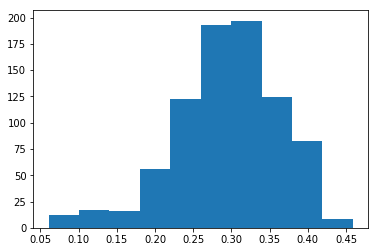

In [97]:
plt.hist([item for sublist in X_pred for item in sublist])

In [98]:
test_data_df

,sent,label,source
0,We ’re also doing some avian and marine mammal...,neutral,anti
1,"In preconstruction monitoring , we ’re looking...",neutral,anti
2,“ This project will have to address the marine...,neutral,anti
3,N.J. “ It is a project with a lot of potential...,neutral,anti
4,that studies need to be done,neutral,anti
...,...,...,...
824,"Thus , as in any facet of life , we must make ...",neutral,pro
825,whether a doubling of CO2 will ultimately resu...,neutral,pro
826,what is a ridiculously complex phenomenon into...,neutral,pro
827,Even if we know some of these are far more imp...,neutral,pro


In [ ]:
X_pred = np.round(model.predict(X_test))
X_pred[X_pred>1]=1
X_pred[X_pred<=0]=-1

print(test_data_df['label'].shape)
print(X_pred.shape)
test_compare = test_data_df
test_compare['pred'] = X_pred
test_compare

same = test_compare[test_compare['label']==test_compare['pred']]
diff_falsepos = test_compare[test_compare['label']<test_compare['pred']]
diff_falseneg = test_compare[test_compare['label']>test_compare['pred']]
print(len(same), len(diff_falsepos), len(diff_falseneg))

diff_falseneg.to_csv('FalseNeg.csv', sep=',')
diff_falsepos.to_csv('FalsePos.csv', sep=',')